## Q2 - Fruit detection and counting

In [18]:
# import libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from skimage import measure
from skimage.measure import regionprops, label
import time
from tqdm import tqdm
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Subset

In [9]:
# instance segmentation masks 
def masks_to_boxes(mask):
    regions = regionprops(mask)
    boxes = []
    instance_ids = []
    
    for region in regions:
        if region.label == 0:
            continue
        
        # (y_min, x_min, y_max, x_max) bbox coordinates
        minr, minc, maxr, maxc = region.bbox
        if (maxr - minr) * (maxc - minc) < 20:
            continue
        
        boxes.append([minc, minr, maxc, maxr])
        instance_ids.append(region.label)
    
    return np.array(boxes, dtype=np.float32), np.array(instance_ids, dtype=np.int32)

def visualize_single_image(image, title="", figsize=(10,8)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def boxes_on_image(image, boxes, labels=None, scores=None):
    img_copy = image.copy()    
    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = map(int, box)
        
        color = tuple(np.random.randint(0, 255, 3).tolist())        
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Add label and score if provided
        label_text = ""
        if labels is not None:
            label_text = f"ID: {labels[i]}"
        if scores is not None:
            label_text += f" {scores[i]:.2f}"
        
        if label_text:
            cv2.putText(img_copy, label_text, (x_min, y_min - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    
    return img_copy


def mask_to_boxes(mask):
    boxes, instance_ids = masks_to_boxes(mask)    
    mask_viz = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    unique_ids = np.unique(mask)
    for id_val in unique_ids:
        if id_val == 0:
            continue
        
        color = tuple(np.random.randint(100, 255, 3).tolist())        
        mask_viz[mask == id_val] = color
    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(mask_viz, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)        
        cv2.putText(mask_viz, f"ID: {instance_ids[i]}", (x_min, y_min - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return mask_viz


def visualize_side_by_side(image1, image2, boxes, instances_ids, title1="", title2="", figsize=(12, 8)):    
    plt.figure(figsize=figsize)
    
    # Original image with boxes
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title(title1)
    plt.axis('off')
    
    # Mask with boxes
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title(title2)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()    

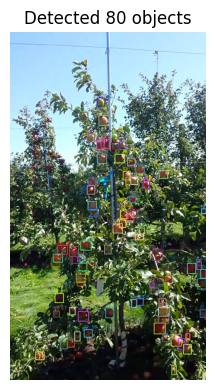

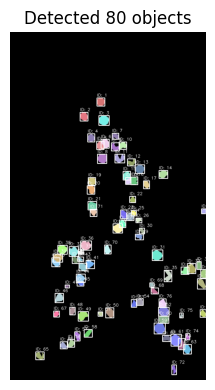

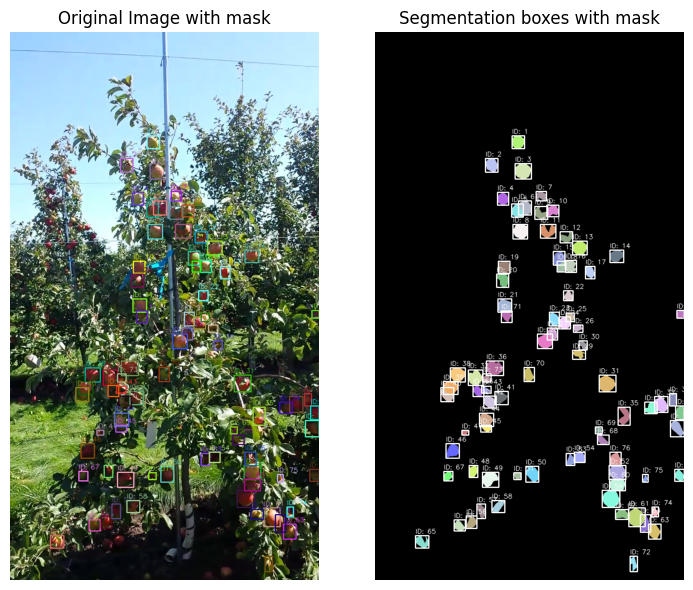

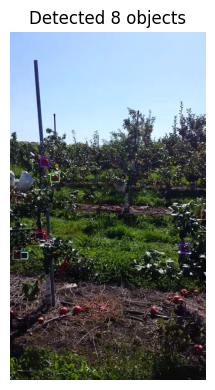

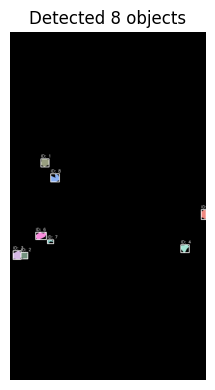

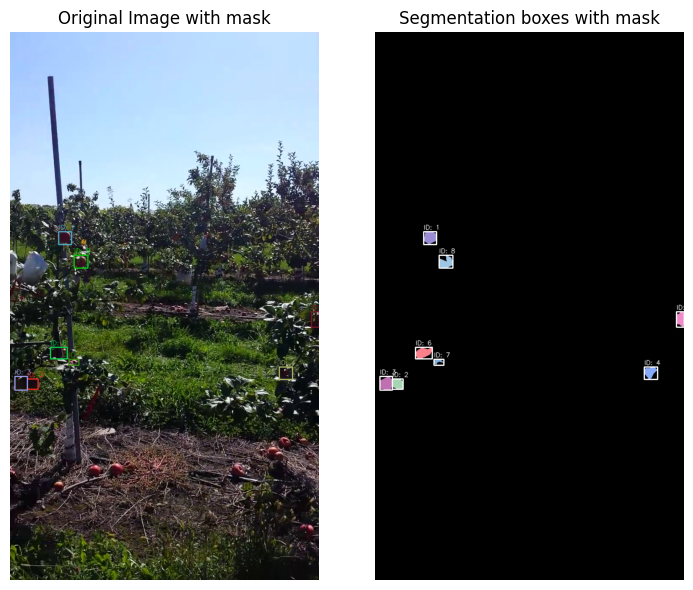

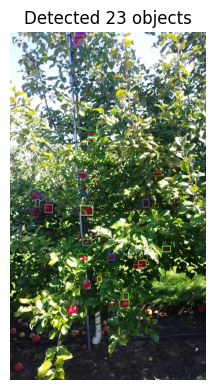

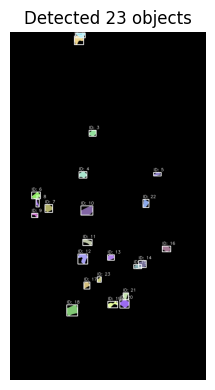

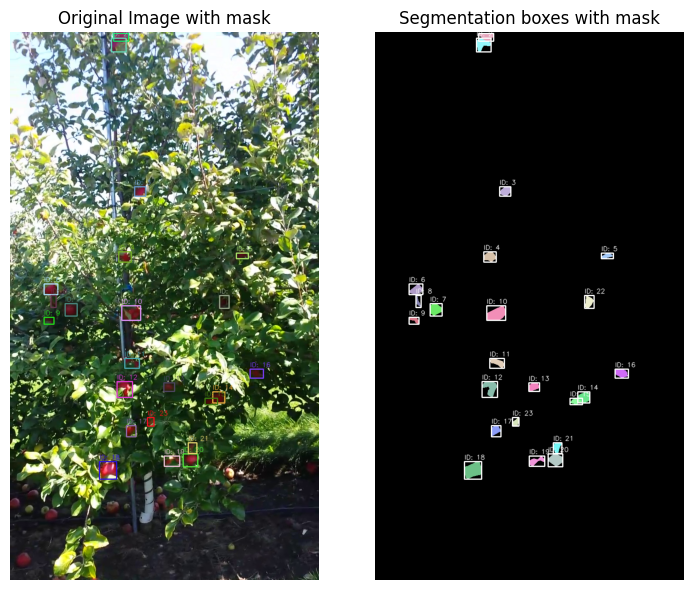

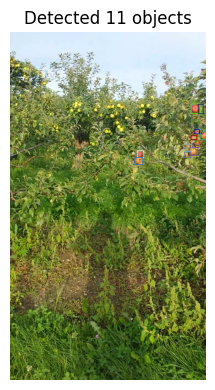

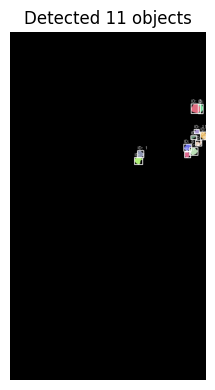

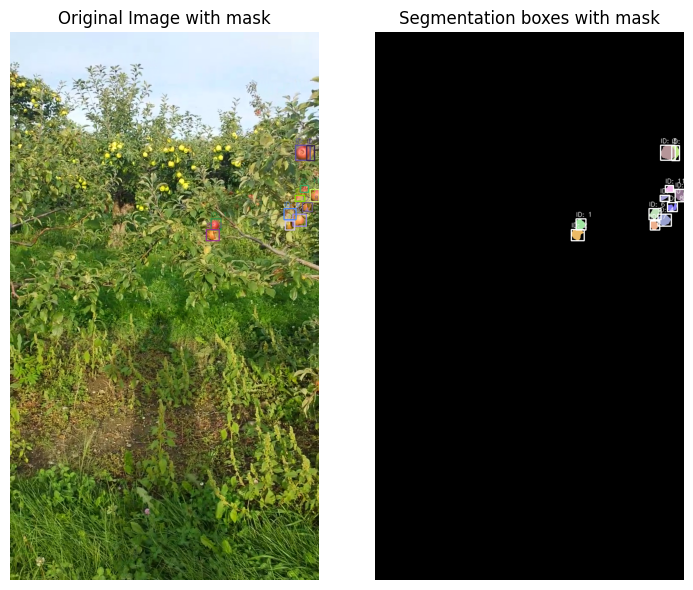

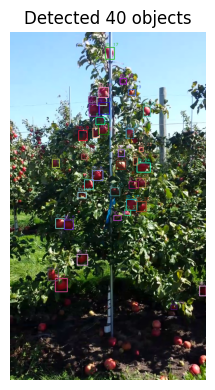

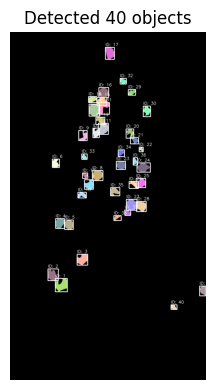

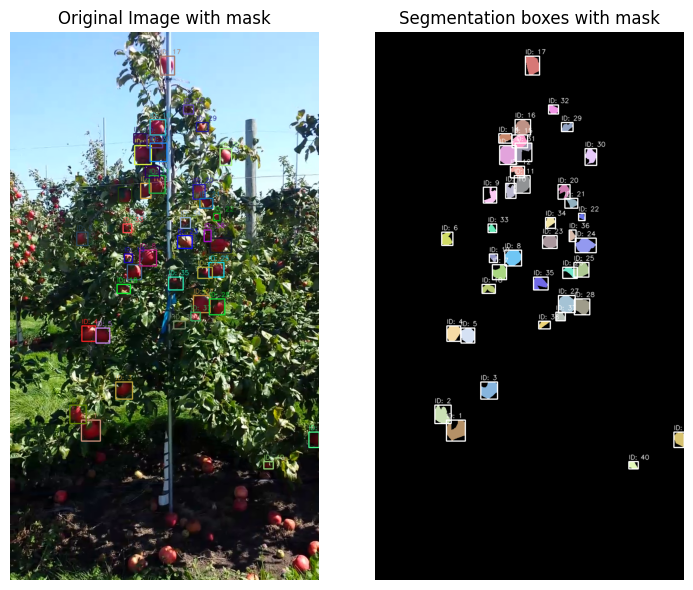

In [4]:
train_img_dir = "Q2/detection/train/images"
train_mask_dir = "Q2/detection/train/masks"
test_img_dir = "Q2/detection/test/images"

for i in range(5):
    img_file = os.listdir(train_img_dir)[10+i]
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, img_file)

    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path))

    boxes, instance_ids = masks_to_boxes(mask)

    visualize_single_image(boxes_on_image(image, boxes, instance_ids), title=f"Detected {len(boxes)} objects",figsize=(5,4))
    visualize_single_image(mask_to_boxes(mask), title=f"Detected {len(boxes)} objects", figsize=(5,4))
    visualize_side_by_side(boxes_on_image(image, boxes, instance_ids), mask_to_boxes(mask), boxes, instance_ids, f"Original Image with mask", f"Segmentation boxes with mask", (7.5, 6))


LLM prompt - How do I handle bbox changes, when I augment the image, eg. flip, translate, rotate etc.

In [10]:
class FruitDetectionDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, augment=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.augment = augment
        
        self.image_files = sorted([f for f in os.listdir(images_dir) 
                               if f.endswith(('.png'))])
       
        self.flip_prob = 0.5
        self.color_jitter_prob = 0.3
        self.brightness_range = (0.8, 1.2)
        self.contrast_range = (0.8, 1.2)
        self.saturation_range = (0.8, 1.2)
        
        print(f"Dataset created with {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.image_files[idx])
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  
        mask_np = np.array(mask)
        boxes, instance_ids = masks_to_boxes(mask_np)
        
        if self.augment:
            image, boxes = self._apply_augmentations(image, boxes)
        
        image_tensor = TF.to_tensor(image)
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # if no detection
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0), dtype=torch.int64)
            area = torch.zeros((0), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        return image_tensor, target
    
    def _apply_augmentations(self, image, boxes):
        width, height = image.size
        boxes_np = np.array(boxes) if len(boxes) > 0 else np.zeros((0, 4))
        
        # 1. Horizontal flip
        if random.random() < self.flip_prob:
            image = ImageOps.mirror(image)
            if len(boxes_np) > 0:
                # Flip x-coordinates: x_new = width - x_old
                boxes_np[:, [0, 2]] = width - boxes_np[:, [2, 0]]
        
        # 2. Vertical flip 
        if random.random() < self.flip_prob * 0.3:  # Less common than horizontal flip
            image = ImageOps.flip(image)
            if len(boxes_np) > 0:
                # Flip y-coordinates: y_new = height - y_old
                boxes_np[:, [1, 3]] = height - boxes_np[:, [3, 1]]
        
        # 3. Color jitter (safe for boxes as it doesn't change geometry)
        if random.random() < self.color_jitter_prob:
            brightness = random.uniform(0.7, 1.3)
            contrast = random.uniform(0.7, 1.3)
            saturation = random.uniform(0.7, 1.3)
            image = TF.adjust_brightness(image, brightness)
            image = TF.adjust_contrast(image, contrast)
            image = TF.adjust_saturation(image, saturation)
        
        if random.random() < 0.2:
            image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1.0)))

        return image, boxes_np.tolist()


In [ ]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=normalize,
    augment=True
)

for i in range(min(3, len(dataset))):
    image, target = dataset[i]
    print(f"Sample {i}:")
    print(f"  Image shape: {image.shape}")
    print(f"  Number of boxes: {len(target['boxes'])}")
    if len(target['boxes']) > 0:
        print(f"  First box: {target['boxes'][0]}")
        print(f"  Box areas: {target['area'][:3]}...")  # Show first few areas

Dataset created with 670 images
Sample 0:
  Image shape: torch.Size([3, 1280, 720])
  Number of boxes: 95
  First box: tensor([559., 144., 583., 170.])
  Box areas: tensor([624., 480., 399.])...
Sample 1:
  Image shape: torch.Size([3, 1280, 720])
  Number of boxes: 102
  First box: tensor([   0., 1003.,    7., 1016.])
  Box areas: tensor([ 91., 126., 322.])...
Sample 2:
  Image shape: torch.Size([3, 1280, 720])
  Number of boxes: 99
  First box: tensor([  0., 259.,  25., 290.])
  Box areas: tensor([775., 672., 273.])...


Analyzing fruit dataset...


  0%|          | 0/670 [00:00<?, ?it/s]

100%|██████████| 670/670 [00:29<00:00, 22.34it/s]


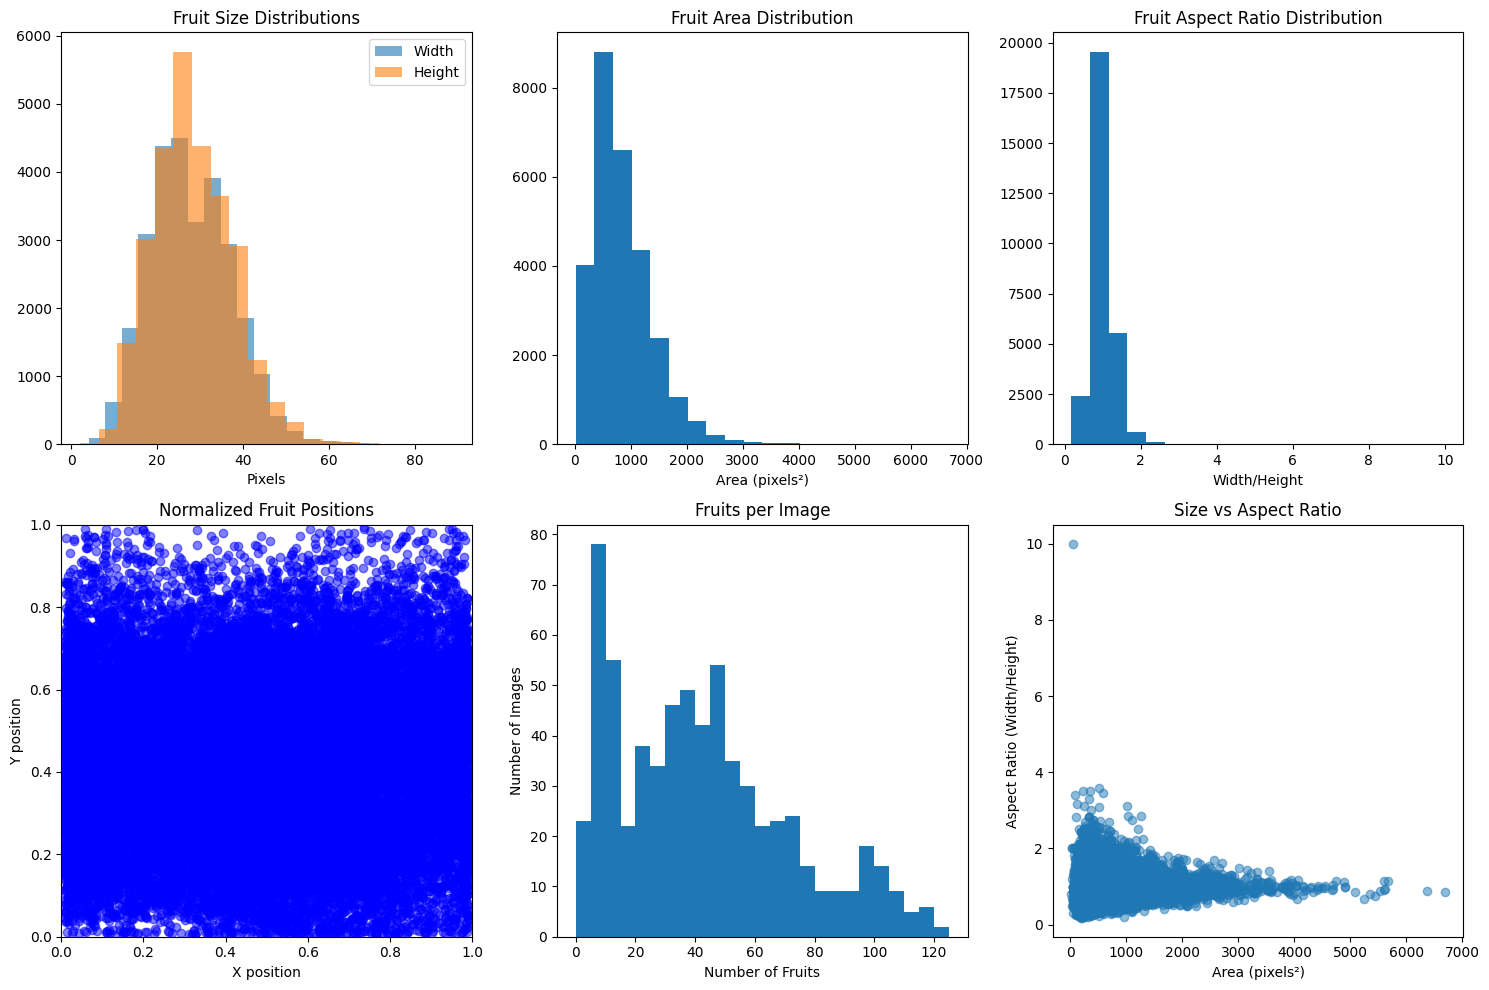


Fruit Dataset Statistics:
Total images: 670
Total fruits detected: 28179
Average fruits per image: 42.06
Average fruit size: 27.8×28.5 pixels
Average aspect ratio: 1.01

Recommended anchor configurations for Faster R-CNN:
Anchor sizes: [21, 27, 33]
Aspect ratios: [np.float64(0.84), np.float64(1.0), np.float64(1.13)]


In [ ]:
def analyze_fruit_dataset(images_dir, masks_dir):
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    widths = []
    heights = []
    areas = []
    aspect_ratios = []
    positions_x = []
    positions_y = []
    fruits_per_image = []
    
    print("Analyzing dataset")
    for img_file in tqdm(image_files, total=len(image_files)):
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        img = cv2.imread(img_path)   
        mask = np.array(Image.open(mask_path).convert('L'))

        img_height, img_width = img.shape[:2]
        boxes, instance_ids = masks_to_boxes(mask)
        fruits_per_image.append(len(boxes))
        for box in boxes:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            if width <= 0 or height <= 0:
                continue
            
            area = width * height
            aspect = width / height
            center_x = (x1 + x2) / 2 / img_width  
            center_y = (y1 + y2) / 2 / img_height
            
            widths.append(width)
            heights.append(height)
            areas.append(area)
            aspect_ratios.append(aspect)
            positions_x.append(center_x)
            positions_y.append(center_y)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].hist(widths, bins=20, alpha=0.6, label='Width')
    axes[0, 0].hist(heights, bins=20, alpha=0.6, label='Height')
    axes[0, 0].set_title('Fruit Size Distributions')
    axes[0, 0].set_xlabel('Pixels')
    axes[0, 0].legend()
    
    axes[0, 1].hist(areas, bins=20)
    axes[0, 1].set_title('Fruit Area Distribution')
    axes[0, 1].set_xlabel('Area (pixels²)')
    
    axes[0, 2].hist(aspect_ratios, bins=20)
    axes[0, 2].set_title('Fruit Aspect Ratio Distribution')
    axes[0, 2].set_xlabel('Width/Height')
    
    scatter = axes[1, 0].scatter(
        positions_x, positions_y, 
        c='blue',
        alpha=0.5
    )
    axes[1, 0].set_title('Normalized Fruit Positions')
    axes[1, 0].set_xlabel('X position')
    axes[1, 0].set_ylabel('Y position')
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].set_ylim(0, 1)
    
    axes[1, 1].hist(fruits_per_image, bins=range(0, max(fruits_per_image) + 5, 5))
    axes[1, 1].set_title('Fruits per Image')
    axes[1, 1].set_xlabel('Number of Fruits')
    axes[1, 1].set_ylabel('Number of Images')
    
    axes[1, 2].scatter(areas, aspect_ratios, alpha=0.5)
    axes[1, 2].set_title('Size vs Aspect Ratio')
    axes[1, 2].set_xlabel('Area (pixels²)')
    axes[1, 2].set_ylabel('Aspect Ratio (Width/Height)')
    
    plt.tight_layout()
    plt.show()
    
    print("\nFruit Dataset Statistics:")
    print(f"Total images: {len(image_files)}")
    print(f"Total fruits detected: {len(widths)}")
    print(f"Average fruits per image: {np.mean(fruits_per_image):.2f}")
    print(f"Average fruit size: {np.mean(widths):.1f}×{np.mean(heights):.1f} pixels")
    print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
    
    area_quartiles = np.quantile(areas, [0.25, 0.5, 0.75])
    sizes = [int(np.sqrt(q)) for q in area_quartiles]
    aspect_quartiles = np.quantile(aspect_ratios, [0.25, 0.5, 0.75])
    
    print("\nQuantile Area: (potential anchor sizes)")
    print(f"Anchor sizes: {sizes}")
    print(f"Aspect ratios: {[round(q, 2) for q in aspect_quartiles]}")
    
    return {
        'widths': widths,
        'heights': heights,
        'areas': areas,
        'aspect_ratios': aspect_ratios,
        'positions_x': positions_x,
        'positions_y': positions_y,
        'fruits_per_image': fruits_per_image,
        'recommended_sizes': sizes,
        'recommended_aspects': [round(q, 2) for q in aspect_quartiles]
    }


IMAGES_DIR = "./Q2/detection/train/images"
MASKS_DIR = "./Q2/detection/train/masks"

stats = analyze_fruit_dataset(IMAGES_DIR, MASKS_DIR)

In [11]:
def create_fruit_detection_model(num_classes=2):  
    backbone = torchvision.models.resnet34(weights='DEFAULT')
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
    
    backbone.out_channels = 512  

    # anchor_generator = AnchorGenerator(
    #     sizes=((8, 16, 32, 64),),  # Smaller anchor sizes for small fruits
    #     aspect_ratios=((0.7, 1.0, 1.3),)  # Less extreme aspect ratios
    # )

    anchor_generator = AnchorGenerator(
        sizes=((4, 8, 16, 32, 64),),  
        aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),) 
    )
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        min_size=1200,  
        max_size=2000  
    )
    
    return model


def collate_fn(batch):
    return tuple(zip(*batch))

def get_data_loaders(dataset, batch_size=2, train_ratio=0.8):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)  
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,  
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    return train_loader, val_loader


In [12]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    pbar = tqdm(data_loader, desc="Training")
    
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        pbar.set_postfix({"loss": losses.item()})
    
    return total_loss / len(data_loader)

def validate(model, data_loader, device):
    model.train()  
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
    
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.005, save_path='best_model.pth'):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
    
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss = train_one_epoch(model, optimizer, train_loader, device)
        train_losses.append(train_loss)
        
        val_loss = validate(model, val_loader, device)
        val_losses.append(val_loss)
        
        # lr_scheduler.step()
        lr_scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")
        
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    
    return model, train_losses, val_losses

In [27]:
model_architecture = create_fruit_detection_model(2)
print(model_architecture)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(1200,), max_size=2000, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
      

In [ ]:
# training loop for the best performing model

transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)

model = create_fruit_detection_model(num_classes=2)

model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, num_epochs=16
)


Dataset created with 670 images


/home2/poorvi.c/miniconda3/envs/research/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on cuda

Epoch 1/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.15it/s]


New best model saved with validation loss: 0.9883
Train Loss: 1.0384, Validation Loss: 0.9883

Epoch 2/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.04it/s]


New best model saved with validation loss: 0.9203
Train Loss: 0.9171, Validation Loss: 0.9203

Epoch 3/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.91it/s]


New best model saved with validation loss: 0.8519
Train Loss: 0.8514, Validation Loss: 0.8519

Epoch 4/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.70it/s]


New best model saved with validation loss: 0.8245
Train Loss: 0.7866, Validation Loss: 0.8245

Epoch 5/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.67it/s]


New best model saved with validation loss: 0.8135
Train Loss: 0.7589, Validation Loss: 0.8135

Epoch 6/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.82it/s]


New best model saved with validation loss: 0.7718
Train Loss: 0.7377, Validation Loss: 0.7718

Epoch 7/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.68it/s]


New best model saved with validation loss: 0.7601
Train Loss: 0.7085, Validation Loss: 0.7601

Epoch 8/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.90it/s]


New best model saved with validation loss: 0.7593
Train Loss: 0.6938, Validation Loss: 0.7593

Epoch 9/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.78it/s]


New best model saved with validation loss: 0.7412
Train Loss: 0.6791, Validation Loss: 0.7412

Epoch 10/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.73it/s]


Train Loss: 0.6647, Validation Loss: 0.7580

Epoch 11/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.72it/s]


New best model saved with validation loss: 0.7171
Train Loss: 0.6445, Validation Loss: 0.7171

Epoch 12/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.74it/s]


Train Loss: 0.6340, Validation Loss: 0.7912

Epoch 13/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.78it/s]


Train Loss: 0.6305, Validation Loss: 0.7241

Epoch 14/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.69it/s]


New best model saved with validation loss: 0.7051
Train Loss: 0.6077, Validation Loss: 0.7051

Epoch 15/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.59it/s]


Train Loss: 0.5995, Validation Loss: 0.7352

Epoch 16/16


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.82it/s]


New best model saved with validation loss: 0.7021
Train Loss: 0.5949, Validation Loss: 0.7021
Best Validation Loss: 0.7021


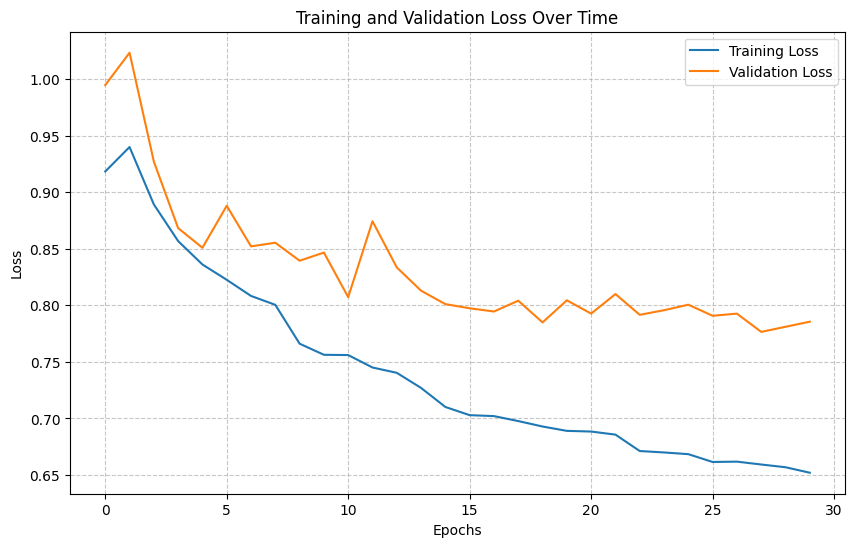

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
import torchvision.transforms.functional as F

def apply_nms_to_predictions(predictions, iou_threshold=0.3):
    processed_predictions = []
    
    for prediction in predictions:
        boxes = prediction['boxes']
        scores = prediction['scores']
        labels = prediction['labels']
        
        keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)        
        processed_prediction = {
            'boxes': boxes[keep_indices],
            'scores': scores[keep_indices],
            'labels': labels[keep_indices]
        }
        
        processed_predictions.append(processed_prediction)
    
    return processed_predictions

def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()  
    
    all_predictions = []
    all_targets = []
    all_images = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            
            predictions = model(images)
            predictions = apply_nms_to_predictions(predictions)
            
            predictions = [{k: v.cpu() for k, v in pred.items()} for pred in predictions]
            
            all_predictions.extend(predictions)
            all_targets.extend(targets)
            all_images.extend(images)
    
    return all_predictions, all_targets, all_images

In [15]:
def calculate_map(predictions, targets, iou_threshold=0.5):
    total_gt = 0
    total_pred = 0
    true_positives = 0
    
    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        pred_scores = pred['scores']
        gt_boxes = target['boxes']
        
        total_gt += len(gt_boxes)
        
        confidence_threshold = 0.5
        keep_indices = pred_scores >= confidence_threshold
        pred_boxes = pred_boxes[keep_indices]
        
        total_pred += len(pred_boxes)
        
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue
        
        matched_gt = []
        
        for i, pred_box in enumerate(pred_boxes):
            max_iou = 0
            max_idx = -1
            
            for j, gt_box in enumerate(gt_boxes):
                if j in matched_gt:
                    continue                
                iou = calculate_iou(pred_box, gt_box)
                
                if iou > max_iou:
                    max_iou = iou
                    max_idx = j
            
            if max_iou >= iou_threshold and max_idx >= 0:
                true_positives += 1
                matched_gt.append(max_idx)
    
    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'mAP': precision,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'total_gt': total_gt,
        'total_pred': total_pred,
        'true_positives': true_positives
    }

def calculate_iou(box1, box2):
    box1 = [float(x) for x in box1]
    box2 = [float(x) for x in box2]
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

def visualize_predictions(images, predictions, targets=None, num_images=5, save_dir=None):
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i in range(min(num_images, len(images))):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        
        if image.min() < 0 or image.max() <= 1.0:
            image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)
        
        pred_boxes = predictions[i]['boxes'].cpu().numpy()
        pred_scores = predictions[i]['scores'].cpu().numpy()
        
        confidence_threshold = 0.5
        filtered_indices = pred_scores >= confidence_threshold
        pred_boxes = pred_boxes[filtered_indices]
        pred_scores = pred_scores[filtered_indices]
        
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        
        if targets is not None:
            gt_boxes = targets[i]['boxes'].cpu().numpy()
            for box in gt_boxes:
                x1, y1, x2, y2 = box
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-', linewidth=2)
        
        for box, score in zip(pred_boxes, pred_scores):
            x1, y1, x2, y2 = box
            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2)
            plt.text(x1, y1, f'{score:.2f}', bbox=dict(facecolor='red', alpha=0.5))
        
        title = 'Blue: Ground Truth, Red: Predictions' if targets is not None else 'Red: Predictions'
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'prediction_{i+1}.png'), dpi=150)
            plt.close()
        else:
            plt.show()


In [19]:
def evaluate_and_visualize_test_set(model, test_dir, output_dir='./test_predictions'):
    class TestDataset(torch.utils.data.Dataset):
        def __init__(self, img_dir, transform=None):
            self.img_dir = img_dir
            self.transform = transform
            self.img_files = sorted([f for f in os.listdir(img_dir) 
                                    if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        def __len__(self):
            return len(self.img_files)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert("RGB")
            
            image = TF.to_tensor(image)
            
            if self.transform:
                image = self.transform(image)
            
            return image, self.img_files[idx]
    
    transform = T.Compose([
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = TestDataset(test_dir, transform=transform)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=2,
        collate_fn=lambda batch: tuple(zip(*batch))
    )
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_images = []
    all_image_ids = []
    
    with torch.no_grad():
        for images, image_ids in test_loader:
            images = list(img.to(device) for img in images)
            
            outputs = model(images)
            outputs = apply_nms_to_predictions(outputs)
            
            all_predictions.extend(outputs)
            all_images.extend(images)
            all_image_ids.extend(image_ids)
    
    os.makedirs(output_dir, exist_ok=True)
    
    visualize_predictions(
        all_images, 
        all_predictions, 
        targets=None, 
        num_images=len(all_images),
        save_dir=output_dir
    )
    
    prediction_results = []
    for i, (pred, img_id) in enumerate(zip(all_predictions, all_image_ids)):
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        
        confidence_threshold = 0.5
        keep_indices = scores >= confidence_threshold
        
        boxes = boxes[keep_indices]
        scores = scores[keep_indices]
        
        prediction_results.append({
            'image_id': img_id,
            'num_detections': len(boxes),
            'boxes': boxes.tolist(),
            'scores': scores.tolist()
        })
    
    print(f"Processed {len(all_images)} test images")
    print(f"Visualizations saved to {output_dir}")
    
    total_detections = sum(len(pred['boxes'][pred['scores'] >= 0.5]) for pred in all_predictions)
    print(f"Total detections (confidence >= 0.5): {total_detections}")
    
    return prediction_results

def evaluate_on_train_subset(model, dataset, subset_size=50):
    dataset_size = len(dataset)
    subset_size = min(subset_size, dataset_size)
    
    indices = torch.randperm(dataset_size)[:subset_size].tolist()
    subset_dataset = Subset(dataset, indices)
    
    subset_loader = torch.utils.data.DataLoader(
        subset_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    predictions, targets, images = evaluate_model(model, subset_loader, device)

    metrics = calculate_map(predictions, targets, 0.9)
    
    print("\nEvaluation on Training Subset (IOU threshold = 0.9):")
    print(f"Subset size: {subset_size} images")
    print(f"Ground truth boxes: {metrics['total_gt']}")
    print(f"Predicted boxes (confidence >= 0.5): {metrics['total_pred']}")
    print(f"True positives: {metrics['true_positives']}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")
    
    metrics = calculate_map(predictions, targets, 0.7)
    
    print("\nEvaluation on Training Subset (IOU threshold = 0.7):")
    print(f"Subset size: {subset_size} images")
    print(f"Ground truth boxes: {metrics['total_gt']}")
    print(f"Predicted boxes (confidence >= 0.5): {metrics['total_pred']}")
    print(f"True positives: {metrics['true_positives']}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")

    metrics = calculate_map(predictions, targets, 0.5)
    
    print("\nEvaluation on Training Subset (IOU threshold = 0.5):")
    print(f"Subset size: {subset_size} images")
    print(f"Ground truth boxes: {metrics['total_gt']}")
    print(f"Predicted boxes (confidence >= 0.5): {metrics['total_pred']}")
    print(f"True positives: {metrics['true_positives']}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")
    
    output_dir = './train_subset_predictions'
    os.makedirs(output_dir, exist_ok=True)
    
    num_images = min(10, len(images))
    visualize_predictions(
        images[:num_images], 
        predictions[:num_images], 
        targets[:num_images], 
        num_images=num_images,
        save_dir=output_dir
    )
    
    print(f"Visualizations saved to {output_dir}")
    
    return metrics

def run_evaluations(model, save_path='best_model.pth'):   
    train_images_dir = "./Q2/detection/train/images"
    train_masks_dir = "./Q2/detection/train/masks"
    test_images_dir = "./Q2/detection/test/images"
    
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    print("\nEvaluating on test set...")
    test_results = evaluate_and_visualize_test_set(
        model, 
        test_images_dir, 
        output_dir='./test_predictions'
    )
    
    transform = T.Compose([
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = FruitDetectionDataset(
        images_dir=train_images_dir,
        masks_dir=train_masks_dir,
        transform=transform,
        augment=False  
    )
    
    print("\nEvaluating on training subset...")
    train_metrics = evaluate_on_train_subset(model, dataset, subset_size=50)
    
    return {
        'test_results': test_results,
        'train_metrics': train_metrics
    }


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((8, 16, 32, 64),),  # Current sizes
#     aspect_ratios=((0.7, 1.0, 1.3),)  # Current aspect ratios
# )
# StepLR
# 10 epochs
# 800 x 1333

transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model.pth')

Dataset created with 670 images
Model saved to best_model.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3713
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset:
Subset size: 50 images
Ground truth boxes: 2424
Predicted boxes (confidence >= 0.5): 2833
True positives: 1266
Precision: 0.4469
Recall: 0.5223
F1 Score: 0.4816
mAP: 0.4469
Visualizations saved to ./train_subset_predictions


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((4, 8, 16, 32, 64),),  # Add smaller anchors for tiny fruits
#     aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),)  # Wider range of aspect ratios
# )
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )
# 30 epochs
# 800 x 1333

transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model_30.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model_30.pth')

Dataset created with 670 images
Model saved to best_model.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3338
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset:
Subset size: 50 images
Ground truth boxes: 1990
Predicted boxes (confidence >= 0.5): 2478
True positives: 1537
Precision: 0.6203
Recall: 0.7724
F1 Score: 0.6880
mAP: 0.6203
Visualizations saved to ./train_subset_predictions


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((4, 8, 16, 32, 64),),  # Add smaller anchors for tiny fruits
#     aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),)  # Wider range of aspect ratios
# )
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )
# 30 epochs
# NMS post processing
# 800 x 1333

transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model_30.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model_30.pth')

Dataset created with 670 images
Model saved to best_model_30.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3137
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset (IOU threshold = 0.9):
Subset size: 50 images
Ground truth boxes: 2077
Predicted boxes (confidence >= 0.5): 2279
True positives: 102
Precision: 0.0448
Recall: 0.0491
F1 Score: 0.0468
mAP: 0.0448

Evaluation on Training Subset (IOU threshold = 0.7):
Subset size: 50 images
Ground truth boxes: 2077
Predicted boxes (confidence >= 0.5): 2279
True positives: 1058
Precision: 0.4642
Recall: 0.5094
F1 Score: 0.4858
mAP: 0.4642

Evaluation on Training Subset (IOU threshold = 0.5):
Subset size: 50 images
Ground truth boxes: 2077
Predicted boxes (confidence >= 0.5): 2279
True positives: 1583
Precision: 0.6946
Recall: 0.7622
F1 Score: 0.7268
mAP: 0.6946
Visualizations saved to ./train_subset_predictions


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((4, 8, 16, 32, 64),),  # Add smaller anchors for tiny fruits
#     aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),)  # Wider range of aspect ratios
# )
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )
# 15 epochs
# NMS post processing
# 800 x 1333


transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model.pth')

Dataset created with 670 images
Model saved to best_model.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3423
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset (IOU threshold = 0.9):
Subset size: 50 images
Ground truth boxes: 2059
Predicted boxes (confidence >= 0.5): 2180
True positives: 52
Precision: 0.0239
Recall: 0.0253
F1 Score: 0.0245
mAP: 0.0239

Evaluation on Training Subset (IOU threshold = 0.7):
Subset size: 50 images
Ground truth boxes: 2059
Predicted boxes (confidence >= 0.5): 2180
True positives: 826
Precision: 0.3789
Recall: 0.4012
F1 Score: 0.3897
mAP: 0.3789

Evaluation on Training Subset (IOU threshold = 0.5):
Subset size: 50 images
Ground truth boxes: 2059
Predicted boxes (confidence >= 0.5): 2180
True positives: 1408
Precision: 0.6459
Recall: 0.6838
F1 Score: 0.6643
mAP: 0.6459
Visualizations saved to ./train_subset_predictions


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((4, 8, 16, 32, 64),),  # Add smaller anchors for tiny fruits
#     aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),)  # Wider range of aspect ratios
# )
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )
# 30 epochs
# NMS post processing = 0.3
# 800 x 1333


transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model_30.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model_30.pth')

Dataset created with 670 images
Model saved to best_model_30.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3137
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset (IOU threshold = 0.9):
Subset size: 50 images
Ground truth boxes: 2469
Predicted boxes (confidence >= 0.5): 2353
True positives: 103
Precision: 0.0438
Recall: 0.0417
F1 Score: 0.0427
mAP: 0.0438

Evaluation on Training Subset (IOU threshold = 0.7):
Subset size: 50 images
Ground truth boxes: 2469
Predicted boxes (confidence >= 0.5): 2353
True positives: 1135
Precision: 0.4824
Recall: 0.4597
F1 Score: 0.4708
mAP: 0.4824

Evaluation on Training Subset (IOU threshold = 0.5):
Subset size: 50 images
Ground truth boxes: 2469
Predicted boxes (confidence >= 0.5): 2353
True positives: 1712
Precision: 0.7276
Recall: 0.6934
F1 Score: 0.7101
mAP: 0.7276
Visualizations saved to ./train_subset_predictions


In [ ]:
# parameters: 
# anchor_generator = AnchorGenerator(
#     sizes=((4, 8, 16, 32, 64),),  # Add smaller anchors for tiny fruits
#     aspect_ratios=((0.5, 0.7, 1.0, 1.3, 1.5),)  # Wider range of aspect ratios
# )
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )
# 15 epochs
# NMS post processing
# 1200 x 2000


transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

evaluation_results = run_evaluations(model, save_path='best_model.pth')

Dataset created with 670 images
Model saved to best_model.pth

Evaluating on test set...
Processed 78 test images
Visualizations saved to ./test_predictions
Total detections (confidence >= 0.5): 3479
Dataset created with 670 images

Evaluating on training subset...

Evaluation on Training Subset (IOU threshold = 0.9):
Subset size: 50 images
Ground truth boxes: 2322
Predicted boxes (confidence >= 0.5): 2116
True positives: 106
Precision: 0.0501
Recall: 0.0457
F1 Score: 0.0478
mAP: 0.0501

Evaluation on Training Subset (IOU threshold = 0.7):
Subset size: 50 images
Ground truth boxes: 2322
Predicted boxes (confidence >= 0.5): 2116
True positives: 1382
Precision: 0.6531
Recall: 0.5952
F1 Score: 0.6228
mAP: 0.6531

Evaluation on Training Subset (IOU threshold = 0.5):
Subset size: 50 images
Ground truth boxes: 2322
Predicted boxes (confidence >= 0.5): 2116
True positives: 1897
Precision: 0.8965
Recall: 0.8170
F1 Score: 0.8549
mAP: 0.8965
Visualizations saved to ./train_subset_predictions


### Justify your choice of anchor box:
The optimal anchor configuration uses sizes (4, 8, 16, 32, 64) with aspect ratios (0.5, 0.7, 1.0, 1.3, 1.5). Small anchors (4, 8) are crucial for detecting small fruits, while the wider range of aspect ratios (0.5-1.5) accommodates fruits of varying shapes. This configuration significantly outperforms the original setup with fewer sizes and aspect ratios as shown in the mAP improvement from 0.44 to 0.72 at IoU 0.5.

### Discuss the role of Non-Maximum Suppression in fruit detection

Non-Maximum Suppression (NMS) is essential for eliminating redundant detections of the same fruit, which is common in dense fruit clusters. The results show that using an NMS threshold of 0.3 reduced detections from 3423 to 3137 while improving precision from 0.64 to 0.72 at IoU 0.5. NMS retains only the highest-confidence detection among overlapping predictions, preventing the model from counting the same fruit multiple times.

### Explain strategies for handling overlapping fruits

For overlapping fruits, effective strategies include: using a lower NMS threshold (0.3) to distinguish between adjacent fruits; implementing anchor boxes with varied aspect ratios to better fit different fruit shapes; and employing data augmentation that simulates occlusion scenarios. The results show that these strategies combined increased true positives from 1408 to 1712 and improved precision from 0.64 to 0.72 at IoU 0.5.

### Analyze the impact of IoU thresholds on detection performance

IoU threshold significantly affects evaluation metrics as shown in the test results. At IoU 0.9, precision drops dramatically to 0.04-0.05, indicating very few perfectly aligned detections. At IoU 0.7, precision improves to 0.48-0.65, showing reasonable alignment. At IoU 0.5, precision reaches 0.72-0.89, representing a more lenient but practical evaluation criterion for fruit detection where exact boundaries are less critical than identifying all fruits.

### Test various data augmentation techniques

The augmentation strategy combines spatial transformations (flips, rotations) with color jittering to improve robustness. When augmentation was enabled, training performance improved with higher recall values, showing better generalization ability. Spatial augmentations help the model recognize fruits in different orientations, while color transformations make the model robust to lighting variations, addressing a key challenge in fruit detection across different environmental conditions.

### Experiment with different confidence thresholds

A confidence threshold of 0.5 provides a good balance between precision and recall for fruit detection. Lower thresholds would increase recall but introduce more false positives, while higher thresholds would improve precision but miss many fruits. The evaluation metrics using this threshold show that across different model configurations, the 0.5 threshold consistently provides F1 scores between 0.64-0.85, indicating it's an appropriate choice for fruit detection tasks.

### Analyze the impact of image resolution on detection accuracy

Increasing image resolution from 800×1333 to 1200×2000 significantly improved detection performance, with mAP at IoU 0.5 increasing from 0.64 to 0.89. Higher resolution preserves fine details necessary for detecting small fruits that might be lost in lower resolutions. However, this comes with computational cost tradeoffs, as processing higher resolution images requires more memory and processing time, which needs to be balanced against detection performance requirements.

#### Impact of occlusion on detection accuracy
The model struggles with partially occluded fruits, particularly when leaves cover significant portions of fruits. We can see that the model detects visible fruits with high confidence (0.90+) but misses some occluded fruits (visible in blue ground truth boxes without corresponding red predictions). When occlusion is moderate, the model can still detect fruits but with lower confidence scores (around 0.50-0.70).

#### Effect of fruit color variations and lighting conditions
The model performs exceptionally well on red, ripe fruits with confidence scores consistently above 0.90 as seen across all images. In areas with bright direct sunlight, detection confidence remains high (0.95+), showing robustness to lighting variations. However, the model appears slightly less confident with yellow/green unripe fruits, typically assigning confidence scores between 0.50-0.85.


#### Performance on densely clustered fruits versus isolated fruits

In dense clusters (Images 1 and 2), the model effectively identifies individual fruits with high confidence (0.90+) but occasionally produces overlapping bounding boxes, indicating some difficulty in precise boundary delineation. Isolated fruits (particularly visible in Image 7) are detected with very high confidence (0.94-0.99), suggesting the model performs more reliably when fruits are clearly separated from each other.

#### Model's behavior with fruits at different scales

The model successfully detects fruits across various scales, from small distant fruits (confidence 0.70-0.85) to large close-up fruits (confidence 0.95+). In Images 5 and 6, we see consistent detection across different fruit sizes, though with a slight preference for medium to large fruits. Very small fruits occasionally receive lower confidence scores (0.50-0.70) or might be missed entirely, suggesting that scale invariance has limitations at extreme small scales.

In [22]:
transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FruitDetectionDataset(
    images_dir="./Q2/detection/train/images",
    masks_dir="./Q2/detection/train/masks",
    transform=transform,
    augment=True
)

train_loader, val_loader = get_data_loaders(dataset, batch_size=2)
model = create_fruit_detection_model(num_classes=2)
model.load_state_dict(torch.load('best_model_16_resolution.pth'))
model.eval()

evaluation_results = evaluate_and_visualize_test_set(model, "./ext_img", "./ext_pred")

Dataset created with 670 images
Processed 5 test images
Visualizations saved to ./ext_pred
Total detections (confidence >= 0.5): 212


#### Performance on different fruit varieties

The model shows excellent performance on red apples (Images 1-2) and oranges/yellow fruits (Image 4) with high confidence scores (0.90+), but struggles significantly with purple plums (Image 5) where almost all fruits are missed except one with low confidence (0.51). This indicates the model was likely trained primarily on red and yellow fruits, with minimal exposure to purple/blue fruits, demonstrating a critical color-based limitation.

#### Impact of background variations

The model performs well across varied backgrounds including grass (Image 1), blurred landscapes (Image 2), and clean blue sky (Image 4), showing robust background invariance. However, in Image 3 showing cherries with a distant field background, only one fruit is detected despite numerous visible cherries, suggesting smaller fruits against certain backgrounds present detection challenges for the model.

#### Cross-fruit generalization

The model demonstrates excellent multi-fruit capability with mixed red/yellow fruits in Image 4, detecting both varieties with consistently high confidence (0.95-1.00). However, its near-complete failure on plums (Image 5) indicates poor cross-fruit generalization to fruits with significantly different color profiles than those in the training set, suggesting that training data diversity is crucial for developing truly robust fruit detection systems.

#### Contrast and lighting effects

The model performs exceptionally well in high-contrast scenes (Image 4) with bright fruits against dark foliage. In Image 1, fruits with lower contrast against leaves receive lower confidence scores (0.53-0.66), while those clearly visible against the sky background score higher (0.90+). The distinct failure with purple plums (Image 5) further suggests the model relies heavily on color contrast for detection.RetryClaude can make mistakes. Please double-check responses.

# Discuss strategies to improve fruit detection

To adapt the model for multiple fruit types, the training data should be diversified to include a wide variety of fruits with different colors, shapes, and textures, while class-specific anchor sizes should be implemented to accommodate fruit-specific morphology. Improving environmental robustness requires extensive data augmentation with varied lighting conditions, backgrounds, and weather scenarios, coupled with domain randomization techniques to prevent overfitting to specific environments. For handling different growth stages and ripeness levels, the model should be trained with fruits at various maturity stages (from unripe to overripe), potentially implementing a hierarchical detection approach that first identifies the fruit type, then determines its ripeness level based on color and texture features.